In [1]:
#https://radimrehurek.com/gensim/models/word2vec.html
#http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/

In [1]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
import sqlite3

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


C:\Users\Simo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Preprocessing

In [2]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()

In [3]:
songs.columns = ['user_id', 'artistname','trackname','playlistname']
songs.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


In [4]:
songs.shape

(12867139, 4)

In [5]:
songs["combined"] = songs["artistname"] + " - " +songs["trackname"]
songs["userplay"] = songs["user_id"] + " - " +songs["playlistname"]


In [6]:
songs.head()

,user_id,artistname,trackname,playlistname,combined,userplay
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010,Elvis Costello - (The Angels Wanna Wear My) Re...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010,Elvis Costello & The Attractions - (What's So ...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010,Tiffany Page - 7 Years Too Late,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010,Elvis Costello & The Attractions - Accidents W...,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010,Elvis Costello - Alison,9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010


In [7]:
#TODO:trakc names need possible cleaning?
songs[songs['artistname'] == 'Pink Floyd'].head()

,user_id,artistname,trackname,playlistname,combined,userplay
896,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Sorrow - Live,Starred,Pink Floyd - Sorrow - Live,07f0fc3be95dcd878966b1f9572ff670 - Starred
1057,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Comfortably Numb,Work playlist,Pink Floyd - Comfortably Numb,07f0fc3be95dcd878966b1f9572ff670 - Work playlist
1058,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Comfortably Numb - Live,Work playlist,Pink Floyd - Comfortably Numb - Live,07f0fc3be95dcd878966b1f9572ff670 - Work playlist
1098,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Echoes - 2011 Remastered Version,Work playlist,Pink Floyd - Echoes - 2011 Remastered Version,07f0fc3be95dcd878966b1f9572ff670 - Work playlist
1099,07f0fc3be95dcd878966b1f9572ff670,Pink Floyd,Eclipse - 2011 Remastered Version,Work playlist,Pink Floyd - Eclipse - 2011 Remastered Version,07f0fc3be95dcd878966b1f9572ff670 - Work playlist


In [8]:
playlists = songs.groupby(['userplay']).filter(lambda x: len(x) > 9)
playlists = playlists.groupby(['userplay']).agg({'combined':lambda x: list(x)})

In [9]:
playlists.head()

,combined
userplay,
00055176fea33f6e027cd3302289378b - favs,"[Jannik Brunke - 18, Green Day - 21 Guns, Shaw..."
0007f3dd09c91198371454c608d47f22 - Fav songs,[Bryan Adams - (Everything I Do) I Do It For Y...
000b0f32b5739f052b9d40fcc5c41079 - Contacta,"[Veronica Maggio - Bas gillar hörn, Titiyo - B..."
000b0f32b5739f052b9d40fcc5c41079 - Gospel,"[The Worship Crew - Brighter Day, Oslo Gospel ..."
000b0f32b5739f052b9d40fcc5c41079 - Starred,"[Java Gospel - A Blessed Christmas Eve, Java G..."


In [10]:
playlists[playlists.index.str.match('0007f3dd09c91198371454c608d47f22 - Fav songs')]

,combined
userplay,
0007f3dd09c91198371454c608d47f22 - Fav songs,[Bryan Adams - (Everything I Do) I Do It For Y...


In [11]:
playlists.shape

(188437, 1)

In [12]:
#TODO:fix redundancy preprocecessing moved at the start
def preprocess(playlist):
    songs = []
    for song in playlist:
        songs.append(song)
            
    return songs


def to_document(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = preprocess(row['combined'])
        documents.append(preprocessed_songs)

    return documents    

In [13]:
documents = to_document(playlists)

In [14]:
len(documents)

188437

## Training Word2vec-music recommender

In [15]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [16]:
#TODO: what should the test and the validation set size be
index = np.random.choice(range(len(documents)), 100000, replace=False)

In [17]:
test = np.array(documents)[index[:100000]].tolist()
validation = np.array(documents)[index[10000:]].tolist()

In [ ]:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

In [18]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

window_size=7
it=20 #increasing this leads to returning words with wrong similarity
sample=0.001 
power_alpha=0.025

size_embedding=50
neg_sample=5
workers=10
min_count=2 #cold start?


model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
                 min_count=min_count, workers=workers, sg=1, iter=it,
                 sample=sample, negative=neg_sample, alpha=power_alpha)

model.train(test,total_examples=len(test), epochs=model.iter)

2019-02-08 14:32:54,960 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-02-08 14:32:54,961 : INFO : collecting all words and their counts
2019-02-08 14:32:54,968 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-08 14:32:55,304 : INFO : PROGRESS: at sentence #10000, processed 673287 words, keeping 391058 word types
2019-02-08 14:32:55,668 : INFO : PROGRESS: at sentence #20000, processed 1366534 words, keeping 666383 word types
2019-02-08 14:32:56,084 : INFO : PROGRESS: at sentence #30000, processed 2036376 words, keeping 882634 word types
2019-02-08 14:32:56,449 : INFO : PROGRESS: at sentence #40000, processed 2683300 words, keeping 1072093 word types
2019-02-08 14:32:56,834 : INFO : PROGRESS: at sentence #50000, processed 3356134 words, keeping 1229593 word types
2019-02-08 14:32:57,223 : INFO : PROGRESS: at sentence #60000, processed 4018092 words, keeping 1383889 word types
2019-02-08 14:32:57,727 : INFO : PROG

2019-02-08 14:33:54,141 : INFO : EPOCH 3 - PROGRESS: at 65.72% examples, 395357 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:33:55,176 : INFO : EPOCH 3 - PROGRESS: at 73.71% examples, 396139 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:33:56,210 : INFO : EPOCH 3 - PROGRESS: at 81.08% examples, 394985 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:33:57,231 : INFO : EPOCH 3 - PROGRESS: at 87.90% examples, 393941 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:33:58,252 : INFO : EPOCH 3 - PROGRESS: at 94.79% examples, 394185 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:33:58,789 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 14:33:58,798 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 14:33:58,836 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 14:33:58,851 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 14:33:58,853 : INFO : worker thread finished; awaiting 

2019-02-08 14:34:40,180 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 14:34:40,201 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 14:34:40,202 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 14:34:40,207 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 14:34:40,228 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 14:34:40,229 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 14:34:40,237 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 14:34:40,280 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 14:34:40,291 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 14:34:40,292 : INFO : EPOCH - 6 : training on 6699998 raw words (5518344 effective words) took 13.6s, 405425 effective words/s
2019-02-08 14:34:41,305 : INFO : EPOCH 7 - 

2019-02-08 14:35:20,382 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 14:35:20,385 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 14:35:20,385 : INFO : EPOCH - 9 : training on 6699998 raw words (5518344 effective words) took 13.4s, 412651 effective words/s
2019-02-08 14:35:21,410 : INFO : EPOCH 10 - PROGRESS: at 6.73% examples, 369860 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:35:22,429 : INFO : EPOCH 10 - PROGRESS: at 14.29% examples, 399422 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:35:23,434 : INFO : EPOCH 10 - PROGRESS: at 21.98% examples, 404030 words/s, in_qsize 20, out_qsize 2
2019-02-08 14:35:24,440 : INFO : EPOCH 10 - PROGRESS: at 29.91% examples, 412506 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:35:25,461 : INFO : EPOCH 10 - PROGRESS: at 37.54% examples, 407656 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:35:26,474 : INFO : EPOCH 10 - PROGRESS: at 45.69% examples, 412599 words/s, in_qsize 19, out

2019-02-08 14:36:05,145 : INFO : EPOCH 13 - PROGRESS: at 38.79% examples, 417715 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:36:06,146 : INFO : EPOCH 13 - PROGRESS: at 46.56% examples, 420944 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:36:07,168 : INFO : EPOCH 13 - PROGRESS: at 54.40% examples, 420972 words/s, in_qsize 20, out_qsize 1
2019-02-08 14:36:08,245 : INFO : EPOCH 13 - PROGRESS: at 62.80% examples, 421931 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:36:09,280 : INFO : EPOCH 13 - PROGRESS: at 71.07% examples, 423136 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:36:10,303 : INFO : EPOCH 13 - PROGRESS: at 79.36% examples, 424079 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:36:11,316 : INFO : EPOCH 13 - PROGRESS: at 87.06% examples, 424189 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:36:12,350 : INFO : EPOCH 13 - PROGRESS: at 94.07% examples, 422518 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:36:12,950 : INFO : worker thread finished; awaiting finish of 9 mo

2019-02-08 14:36:51,945 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 14:36:51,980 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 14:36:51,987 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 14:36:51,988 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 14:36:52,004 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 14:36:52,015 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 14:36:52,024 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 14:36:52,038 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 14:36:52,060 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 14:36:52,101 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 14:36:52,103 : INFO : EPOCH - 16 : training on 6699998 raw words (5518344 effec

2019-02-08 14:37:30,059 : INFO : EPOCH - 19 : training on 6699998 raw words (5518344 effective words) took 12.7s, 433111 effective words/s
2019-02-08 14:37:31,078 : INFO : EPOCH 20 - PROGRESS: at 7.18% examples, 393517 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:37:32,083 : INFO : EPOCH 20 - PROGRESS: at 14.88% examples, 417849 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:37:33,119 : INFO : EPOCH 20 - PROGRESS: at 23.12% examples, 420783 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:37:34,125 : INFO : EPOCH 20 - PROGRESS: at 31.35% examples, 428802 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:37:35,154 : INFO : EPOCH 20 - PROGRESS: at 39.75% examples, 428242 words/s, in_qsize 20, out_qsize 1
2019-02-08 14:37:36,177 : INFO : EPOCH 20 - PROGRESS: at 47.64% examples, 428738 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:37:37,212 : INFO : EPOCH 20 - PROGRESS: at 55.93% examples, 430567 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:37:38,224 : INFO : EPOCH 20 - PROGRESS: at 

2019-02-08 14:38:12,979 : INFO : EPOCH 3 - PROGRESS: at 30.88% examples, 425785 words/s, in_qsize 20, out_qsize 1
2019-02-08 14:38:13,984 : INFO : EPOCH 3 - PROGRESS: at 39.75% examples, 432657 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:38:14,987 : INFO : EPOCH 3 - PROGRESS: at 47.19% examples, 429531 words/s, in_qsize 20, out_qsize 1
2019-02-08 14:38:16,019 : INFO : EPOCH 3 - PROGRESS: at 55.27% examples, 429126 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:38:17,072 : INFO : EPOCH 3 - PROGRESS: at 63.71% examples, 431000 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:38:18,074 : INFO : EPOCH 3 - PROGRESS: at 72.06% examples, 432802 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:38:19,102 : INFO : EPOCH 3 - PROGRESS: at 80.42% examples, 432936 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:38:20,109 : INFO : EPOCH 3 - PROGRESS: at 88.21% examples, 433472 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:38:21,128 : INFO : EPOCH 3 - PROGRESS: at 96.14% examples, 434557 words/s,

2019-02-08 14:38:59,406 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 14:38:59,408 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 14:38:59,441 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 14:38:59,457 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 14:38:59,462 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 14:38:59,468 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-08 14:38:59,478 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-08 14:38:59,487 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-08 14:38:59,506 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 14:38:59,537 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 14:38:59,538 : INFO : EPOCH - 6 : training on 6699998 raw words (5518344 effect

2019-02-08 14:39:37,774 : INFO : EPOCH 10 - PROGRESS: at 7.61% examples, 420725 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:39:38,786 : INFO : EPOCH 10 - PROGRESS: at 15.25% examples, 430838 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:39:39,801 : INFO : EPOCH 10 - PROGRESS: at 24.10% examples, 440762 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:39:40,814 : INFO : EPOCH 10 - PROGRESS: at 32.33% examples, 444229 words/s, in_qsize 20, out_qsize 1
2019-02-08 14:39:41,815 : INFO : EPOCH 10 - PROGRESS: at 41.10% examples, 447272 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:39:42,837 : INFO : EPOCH 10 - PROGRESS: at 49.39% examples, 448050 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:39:43,844 : INFO : EPOCH 10 - PROGRESS: at 58.02% examples, 449597 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:39:44,850 : INFO : EPOCH 10 - PROGRESS: at 65.80% examples, 447885 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:39:45,852 : INFO : EPOCH 10 - PROGRESS: at 74.03% examples, 447144 

2019-02-08 14:40:22,895 : INFO : EPOCH 13 - PROGRESS: at 72.06% examples, 433789 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:40:23,911 : INFO : EPOCH 13 - PROGRESS: at 80.42% examples, 434333 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:40:24,918 : INFO : EPOCH 13 - PROGRESS: at 88.12% examples, 434712 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:40:25,922 : INFO : EPOCH 13 - PROGRESS: at 96.25% examples, 436787 words/s, in_qsize 20, out_qsize 2
2019-02-08 14:40:26,200 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 14:40:26,237 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 14:40:26,240 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 14:40:26,252 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 14:40:26,254 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 14:40:26,273 : INFO : worker thread finished; awaiting finish of 4 more th

2019-02-08 14:41:02,651 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-08 14:41:02,660 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-08 14:41:02,662 : INFO : EPOCH - 16 : training on 6699998 raw words (5518344 effective words) took 12.1s, 457467 effective words/s
2019-02-08 14:41:03,703 : INFO : EPOCH 17 - PROGRESS: at 7.80% examples, 418194 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:41:04,707 : INFO : EPOCH 17 - PROGRESS: at 15.86% examples, 442866 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:41:05,718 : INFO : EPOCH 17 - PROGRESS: at 24.66% examples, 452615 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:41:06,720 : INFO : EPOCH 17 - PROGRESS: at 33.48% examples, 459062 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:41:07,752 : INFO : EPOCH 17 - PROGRESS: at 42.39% examples, 456929 words/s, in_qsize 20, out_qsize 0
2019-02-08 14:41:08,785 : INFO : EPOCH 17 - PROGRESS: at 50.70% examples, 456868 words/s, in_qsize 20, ou

2019-02-08 14:41:48,143 : INFO : EPOCH 20 - PROGRESS: at 72.45% examples, 436383 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:41:49,187 : INFO : EPOCH 20 - PROGRESS: at 81.40% examples, 438444 words/s, in_qsize 19, out_qsize 0
2019-02-08 14:41:50,207 : INFO : EPOCH 20 - PROGRESS: at 89.14% examples, 440042 words/s, in_qsize 18, out_qsize 1
2019-02-08 14:41:51,227 : INFO : EPOCH 20 - PROGRESS: at 97.58% examples, 441966 words/s, in_qsize 17, out_qsize 0
2019-02-08 14:41:51,378 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-08 14:41:51,396 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-08 14:41:51,413 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-08 14:41:51,432 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-08 14:41:51,434 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-08 14:41:51,435 : INFO : worker thread finished; awaiting finish of 4 more th

(110366880, 133999960)

## Evaluating recommendations

In [19]:
#works badly on rock songs
#w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "Smoke on the Water"
#w1 = "Sweet Emotion"

#
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "A Flock Of Seagulls - I Ran"
#w1 = "Talking Heads - Take Me To The River"

#https://en.wikipedia.org/wiki/List_of_Billboard_Year-End_number-one_singles_and_albums

#w1 = "Simon & Garfunkel - Bridge over Troubled Water"
#w1 = "Three Dog Night - Joy to the World"
#w1 = "Roberta Flack - The First Time Ever I Saw Your Face"
#w1 = "Tony Orlando and Dawn - Tie a Yellow Ribbon 'Round the Ole Oak Tree"
#w1 = "Barbra Streisand - The Way We Were"

#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "Dionne & Friends - That's What Friends Are For"
#w1 = "The Bangles - Walk Like an Egyptian"

#w1 = "Elvis Costello & The Attractions - Oliver's Army"
#model.wv.most_similar(positive=['Bohemian Rhapsody'], negative=['Smoke on the Water'], topn=1)

#w1 = "The Police - Every Breath You Take"
#w1 ="Eminem - Without Me"
#w1="Aqua - Barbie Girl"


#w1="The Cranberries - Dreams"
#w1="Dolly Parton - Jolene"
#w1="Pink Floyd - Wish You Were Here"

w1="Dio - Holy Diver"
model.wv.most_similar(positive=w1, topn=20)

2019-02-08 14:43:06,813 : INFO : precomputing L2-norms of word weight vectors


[('Mötley Crüe - Home Sweet Home', 0.8785232901573181),
 ('Mötley Crüe - Home Sweet Home - International', 0.8708791732788086),
 ('Dream Theater - Home [Scene Six] [Edited Version]', 0.8665485978126526),
 ('Pantera - Hole In The Sky - Non LP Track', 0.850511908531189),
 ('Krokus - Hoodoo Woman', 0.8490731120109558),
 ('Iron Maiden - Holy Smoke', 0.8455684781074524),
 ('Black Sabbath - Hole in the Sky', 0.8440392017364502),
 ('Iron Maiden - Holy Smoke - 1998 - Remaster', 0.841919481754303),
 ('Five Finger Death Punch - House of The Rising Sun', 0.8274434804916382),
 ('Firehouse - Home Is Where the Heart Is', 0.8271273970603943),
 ('Dio - Hungry For Heaven', 0.8268067240715027),
 ('Megadeth - Holy Wars...The Punishment Due - 2004 Digital Remaster',
  0.8255431056022644),
 ('Whitesnake - Here I Go Again - 2011 Remastered Version',
  0.8254215717315674),
 ('Dio - Hide In The Rainbow', 0.8244947195053101),
 ('Iron Maiden - Holy Smoke - 1998 Remastered Version', 0.8237075805664062),
 ('Faste

In [37]:
#model.similarity('Bohemian Rhapsody', 'Smoke on the Water')

In [214]:
vocab = list(model.wv.vocab)
X = model[vocab]
X.shape

C:\Users\Simo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(49756, 50)

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [231]:
index = np.random.choice(range(len(X)), 242, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [247]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(subset_x)

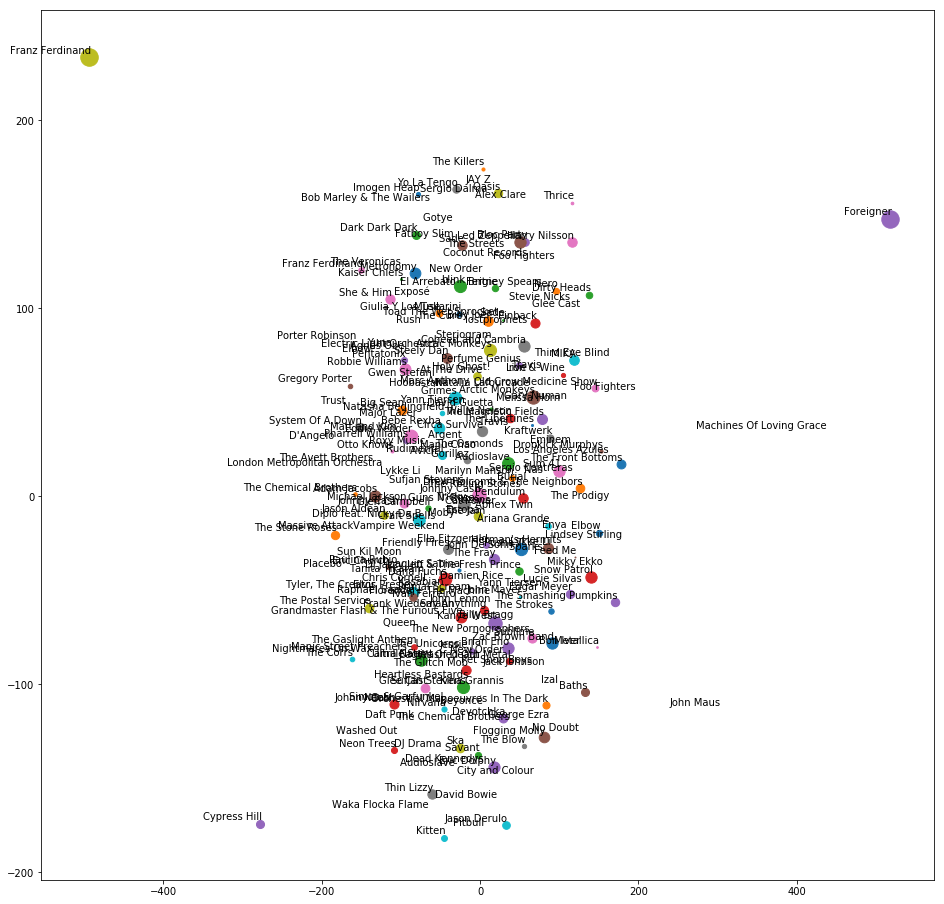

In [250]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        print("ge")
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1],X_tsne[i,2])
    plt.annotate(label_format(labels[i], 1),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [234]:
from sklearn.cluster import KMeans  

In [251]:
kmeans = KMeans(n_clusters=5)  
kmeans.fit(X_tsne)  

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

C:\Users\Simo\Anaconda3\lib\site-packages\matplotlib\collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


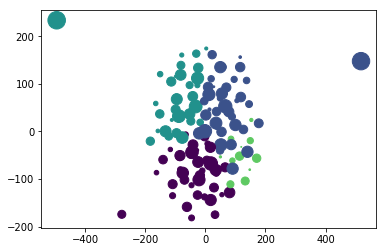

In [252]:
plt.scatter(X_tsne[:,0],X_tsne[:,1],X_tsne[:,2], c=kmeans.labels_)